# Color correction experiment

In [1]:
from exp.nb_Tesis import *


In [2]:
# pip install --upgrade efficientnet-pytorch


In [3]:
urls2019 = ['https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip',
        'https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv']

In [4]:
# for idx,url in enumerate(urls2019):
#   !wget $url

In [5]:
# !unzip ISIC_2019_Training_Input.zip

In [6]:
min_dim = 128# 448

trainImagesFolderName = 'ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'


In [7]:
df = pd.read_csv(trainingGroundTruthFileName); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [9]:
#export
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

#### Prune the dataset if needed

In [11]:
labels_exclusive_for_2019 = ['SCC']
training_for_2018 = True
max_of_each = 30
classDict = {}
images = get_image_files(trainImagesFolderName)
newFolder = f'picked_{max_of_each}_{trainImagesFolderName}'
destFolder = Path(newFolder)
destFolder.mkdir(parents=True, exist_ok=True);

def prune_dataset(image,idx):
    label = get_label_for_image_path(image)
    if training_for_2018 and label in labels_exclusive_for_2019: return
    if label in classDict: classDict[label] = classDict[label] + 1
    else: classDict[label] = 1
    if classDict[label] < max_of_each:
        !cp './'$image $destFolder'/'
#         print(classDict[label],max_of_each)

# parallel(partial(prune_dataset),images)
    

#### Remove warnings

In [12]:
!nvidia-smi

Sat Mar  7 18:10:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 23%   30C    P8    16W / 250W |     12MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [14]:
# torch.cuda.set_device(0)

## Load the dataset

In [15]:
destFolder

PosixPath('picked_30_ISIC_2019_Training_Input')

In [16]:
def reload_dataset(imgs_folder):
    random_seed(1,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.8, max_lighting=.3,p_affine=1, max_warp=0)

    data = ImageList.from_folder(imgs_folder)\
    .split_by_rand_pct()\
    .label_from_func(get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(destFolder)

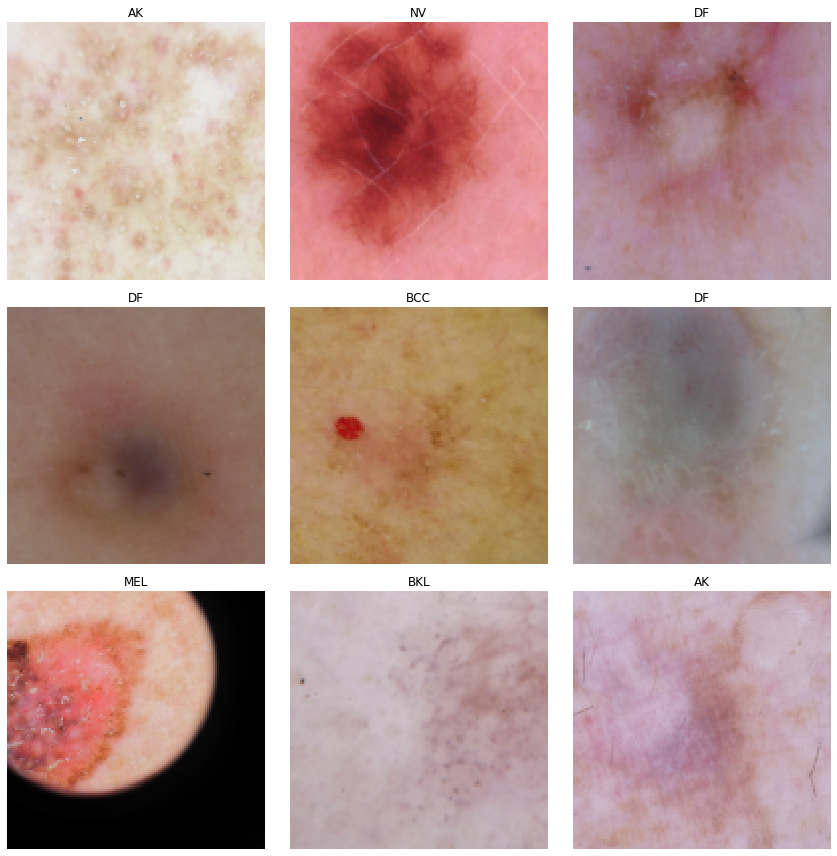

In [17]:
data.show_batch(3)

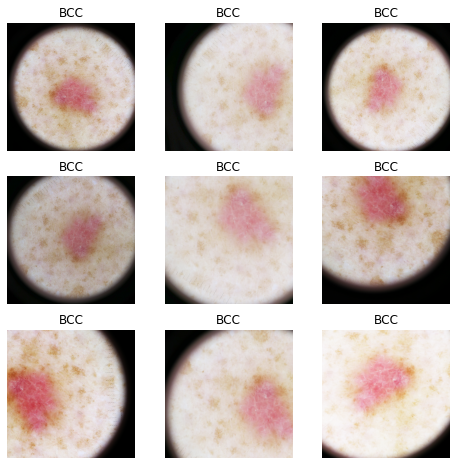

In [18]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [19]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 BCC     381
MEL     374
NV      366
BKL     363
AK      362
VASC    203
DF      201
dtype: int64 

 valid_count: 
 AK      102
BKL     101
NV       98
MEL      90
BCC      83
VASC     50
DF       38
dtype: int64
ratios:
AK      0.281768
BCC     0.217848
BKL     0.278237
DF      0.189055
MEL     0.240642
NV      0.267760
VASC    0.246305
dtype: float64 %


In [20]:
#export

# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

def get_class_weights(data):
    train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
    train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

    weighted_classes = [{c: (sum(train_count) / train_count[c] * len(data.classes))} for c in data.classes];
    print(weighted_classes)
    formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ]
    class_weights=torch.FloatTensor(formatted_weights).cuda()
    class_weights = class_weights / sum(class_weights)
    return class_weights

def train_learner(learner, name, epochs=8, lr=1e-3, wd = 1e-4, balanced=True):
    if balanced: learner.loss_func = CrossEntropyFlat(weight = get_class_weights(learner.data))
    random_seed(1,True)
    log_name = f'2019_imgsz_{learner.data.valid_ds[0][0].shape[1]}_{name}'
    print("Saving log on: ",log_name)
    learner.fit_one_cycle(epochs,max_lr=lr,wd=wd, callbacks = [
        SaveModelCallback(learn=learner,name=log_name,monitor='accuracy'),
        CSVLogger(learn=learner,filename=log_name)
    #     ReduceLROnPlateauCallback(learn=learn)
    ])

## Color correction

In [21]:
def max_rgb(image):
  # First get the maximum across the rows, then take the values and take the maximum again (this time dimension 1 will be the columns)
  return image.max(dim=1)[0].max(dim=1)[0]
  
def computeGrayWorldOnChannel(image, channel,p):
    I_cx = image[channel].sum()
    img_size = image[channel].shape.numel()
    return ( (I_cx ** p) / img_size )  ** (1/p) 

def shades_of_gray(img, p):
    n_channels, height, width  = img.shape
    iluminant = torch.zeros(3)
    for channel in range(n_channels):
        iluminant[channel] = computeGrayWorldOnChannel(img,channel,p)
    return iluminant

In [22]:
def correct_iluminant(estimated_iluminant):
    gamma = (torch.ones(3) / math.sqrt(3))
    corrected_iluminant = gamma * (1 / estimated_iluminant)
    return corrected_iluminant

def correct_image(image,estimated_iluminant):
    corrected_iluminant = correct_iluminant(estimated_iluminant)
    mat_iluminant = corrected_iluminant[:,None,None].expand(image.shape)
    c = mat_iluminant * image
    return c

In [46]:
def _correct_color_max_rgb(image):
    estimated_iluminant = max_rgb(image);

    c = correct_image(image,estimated_iluminant)
    return c

def _correct_color_shades_of_gray(image):
    estimated_iluminant = shades_of_gray(image,1);

    c = correct_image(image,estimated_iluminant)
    return torch.clamp(c,0,1)

correct_color_max_rgb = TfmPixel(_correct_color_max_rgb)
correct_color_shades_of_gray = TfmPixel(_correct_color_shades_of_gray)

### Testing Visualization

#### Max RGB

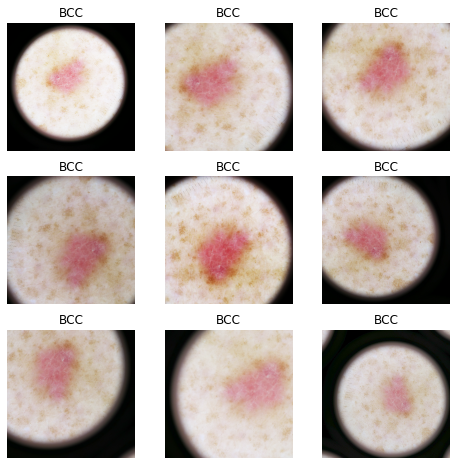

In [25]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

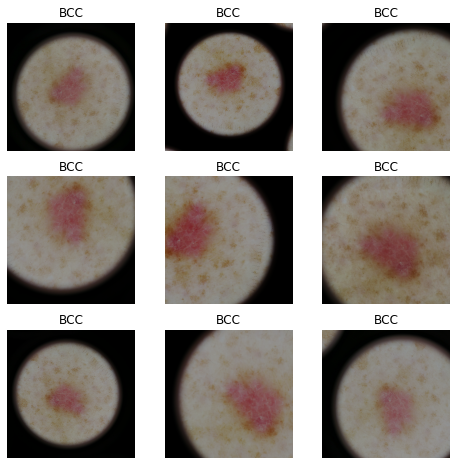

In [26]:
data.train_ds.tfms.insert(0,correct_color_max_rgb());
plot_multi(_plot, 3, 3, figsize=(8,8))

#### Shades of gray

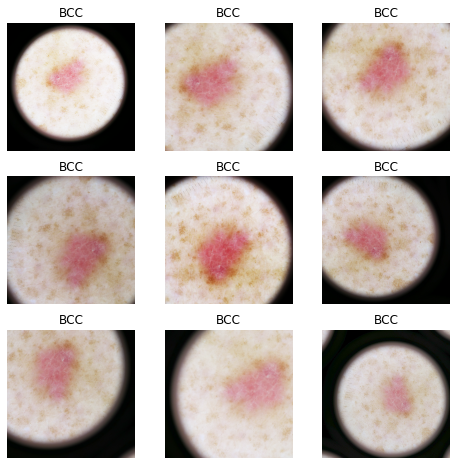

In [27]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

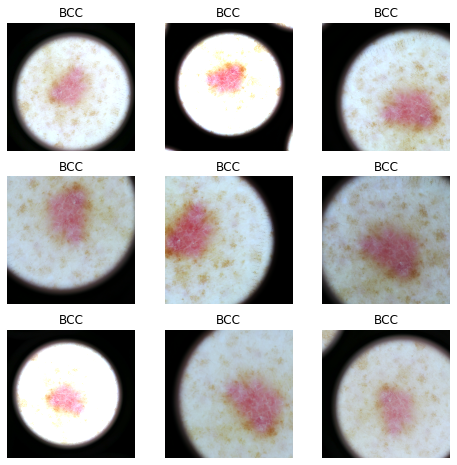

In [28]:
data.train_ds.tfms.insert(0,correct_color_shades_of_gray());
plot_multi(_plot, 3, 3, figsize=(8,8))

# Training

First let's see the baseline result
* Images prerezised to: 128px

* get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1, max_warp=0)
* batch_size = 16
* random_seed 1
* epochs = 8 
* one_cycle_policy, max_lr = 1e-3, wd 1e-4
* balancing per class: True
* pretrained = True
* unfreezed = True
* Efficientnet-b1

train_count: 
 BKL     313
NV      311
AK      305
MEL     300
BCC     297
SCC     278
VASC    196
DF      192
dtype: int64 

 valid_count: 
 BCC     80
AK      80
MEL     78
SCC     70
BKL     69
NV      66
VASC    57
DF      47
dtype: int64

### Without color correction

In [32]:
images_folder = 'picked_30_ISIC_2019_Training_Input'
data = reload_dataset(images_folder)

In [33]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                ])

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.634818,1.436159,0.539146,0.460854,0.624293,00:14
1,1.376907,1.307250,0.517794,0.482206,0.526423,00:14
2,1.295629,1.389935,0.492883,0.507117,0.321302,00:14
3,1.174619,1.419769,0.523132,0.476868,0.515909,00:14
4,1.042902,1.058657,0.398576,0.601424,0.507106,00:14
5,0.935697,1.006752,0.402135,0.597865,0.405488,00:14
6,0.783146,0.900418,0.359431,0.640569,0.449606,00:14
7,0.733985,0.861521,0.346975,0.653025,0.401942,00:18


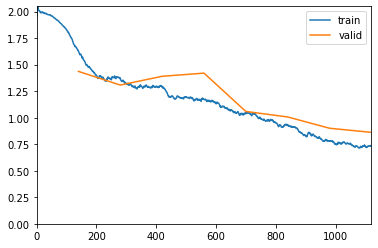

Better model found at epoch 0 with accuracy value: 0.46085408329963684.
Better model found at epoch 1 with accuracy value: 0.48220640420913696.
Better model found at epoch 2 with accuracy value: 0.5071174502372742.
Better model found at epoch 4 with accuracy value: 0.6014235019683838.
Better model found at epoch 6 with accuracy value: 0.6405693888664246.
Better model found at epoch 7 with accuracy value: 0.6530249118804932.


RuntimeError: Could not infer dtype of NoneType

In [34]:
train_learner(learn_b0,'EfficientNet-b0')

## With color correction

### Max RGB

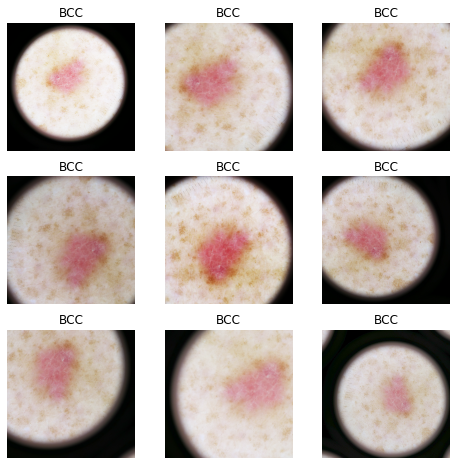

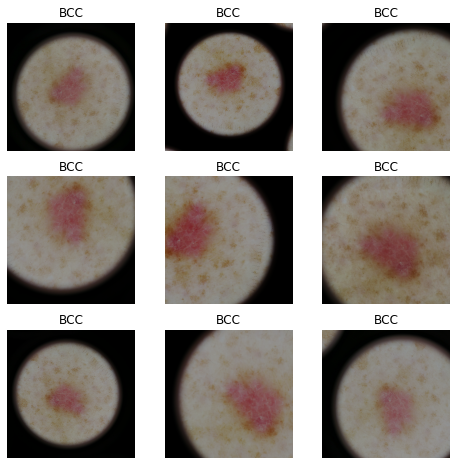

In [35]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

# Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion
data.train_ds.tfms.insert(0,correct_color_max_rgb());
data.valid_ds.tfms.insert(0,correct_color_max_rgb());
plot_multi(_plot, 3, 3, figsize=(8,8))

In [36]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_max_rgb = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                ])

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.633677,1.507069,0.567616,0.432384,0.566466,00:26
1,1.331723,1.357922,0.530249,0.469751,0.374852,00:22
2,1.260277,1.520335,0.512456,0.487544,0.376487,00:14
3,1.141873,1.185188,0.444840,0.555160,0.490681,00:14
4,1.042089,1.085928,0.423488,0.576512,0.460824,00:14
5,0.887722,1.021380,0.405694,0.594306,0.445255,00:14
6,0.754126,0.898121,0.352313,0.647687,0.435144,00:14
7,0.730854,0.881986,0.338078,0.661922,0.404432,00:14


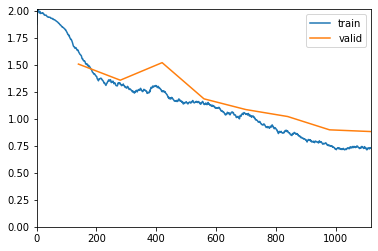

Better model found at epoch 0 with accuracy value: 0.43238434195518494.
Better model found at epoch 1 with accuracy value: 0.46975088119506836.
Better model found at epoch 2 with accuracy value: 0.4875444769859314.
Better model found at epoch 3 with accuracy value: 0.5551601648330688.
Better model found at epoch 4 with accuracy value: 0.5765124559402466.
Better model found at epoch 5 with accuracy value: 0.5943060517311096.
Better model found at epoch 6 with accuracy value: 0.6476868391036987.
Better model found at epoch 7 with accuracy value: 0.6619216799736023.


RuntimeError: Could not infer dtype of NoneType

In [37]:
train_learner(learn_b0_max_rgb,'EfficientNet-b0')

### Shades of Gray

AttributeError: 'functools.partial' object has no attribute '__name__'

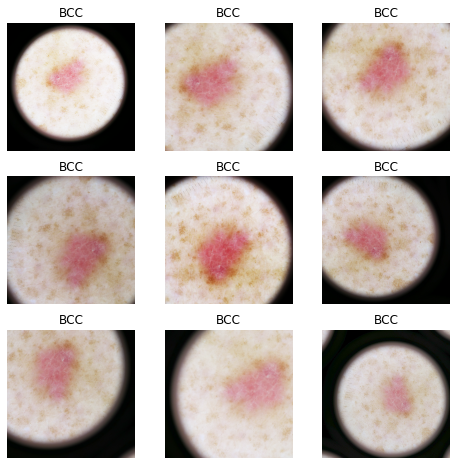

In [47]:
data = reload_dataset(destFolder)
plot_multi(_plot, 3, 3, figsize=(8,8))

# Insertamos en train como en valid ds, la correcion de color Max rgb en la primer posicion
data.train_ds.tfms.insert(0,correct_color_shades_of_gray(1));
data.valid_ds.tfms.insert(0,correct_color_shades_of_gray(1));
plot_multi(_plot, 3, 3, figsize=(8,8))

In [39]:
from efficientnet_pytorch import EfficientNet

random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_shades_of_gray = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                ])

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.633441,1.414910,0.526690,0.473310,0.639057,00:14
1,1.351759,1.326860,0.524911,0.475089,0.444727,00:14
2,1.306087,1.949483,0.590747,0.409253,0.471011,00:14
3,1.136105,1.249725,0.446619,0.553381,0.453279,00:14
4,1.061900,1.163717,0.448399,0.551601,0.498529,00:14
5,0.902910,1.061150,0.411032,0.588968,0.428931,00:14
6,0.777000,0.908309,0.355872,0.644128,0.503911,00:14
7,0.726018,0.892554,0.362989,0.637011,0.480368,00:14


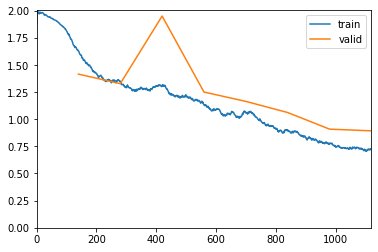

Better model found at epoch 0 with accuracy value: 0.47330960631370544.
Better model found at epoch 1 with accuracy value: 0.4750889539718628.
Better model found at epoch 3 with accuracy value: 0.5533807873725891.
Better model found at epoch 5 with accuracy value: 0.5889679789543152.
Better model found at epoch 6 with accuracy value: 0.6441280841827393.


RuntimeError: Could not infer dtype of NoneType

In [40]:
train_learner(learn_b0_shades_of_gray,'EfficientNet-b0')

### Shades of gray más tranqui